<a href="https://colab.research.google.com/github/WaiWasabi/Tensorflow-Certification-Prep/blob/main/Images/Load%20Images%20from%20Disk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import PIL
import os
import matplotlib.pyplot as plt

import pathlib

# Download Images & Create Dataset



In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

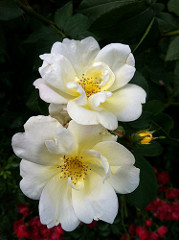

In [3]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [4]:
batch_size = 32
img_height = 180
img_width = 180
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, image_size=(img_height, img_width), seed=123, batch_size=batch_size, validation_split=0.2, subset='training')
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, image_size=(img_height, img_width), seed=123, batch_size=batch_size, validation_split=0.2, subset='validation')

labels = train_ds.class_names
print("\n" + str(labels))

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# Show Sample Images

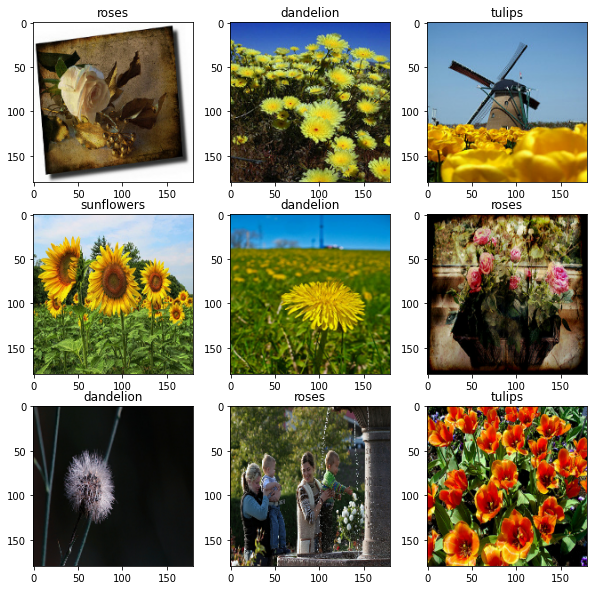

In [5]:
plt.figure(figsize=(10,10))
for image, label in train_ds.take(1):
  for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(labels[label[i]])

# Configure Dataset for Performance

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create Model

In [7]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3)))
model.add(tf.keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(64, 3, padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(5))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

# Compile and Fit

In [8]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [9]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
92/92 [==============================] - 2s 25ms/step - loss: 1.2646 - accuracy: 0.4680 - val_loss: 1.1170 - val_accuracy: 0.5272
Epoch 2/10
92/92 [==============================] - 1s 12ms/step - loss: 0.9712 - accuracy: 0.6165 - val_loss: 1.0202 - val_accuracy: 0.5858
Epoch 3/10
92/92 [==============================] - 1s 12ms/step - loss: 0.8290 - accuracy: 0.6775 - val_loss: 0.8762 - val_accuracy: 0.6635
Epoch 4/10
92/92 [==============================] - 1s 12ms/step - loss: 0.6474 - accuracy: 0.7541 - val_loss: 0.9179 - val_accuracy: 0.6512
Epoch 5/10
92/92 [==============================] - 1s 13ms/step - loss: 0.4577 - accuracy: 0.8341 - val_loss: 0.9386 - val_accuracy: 0.6621
Epoch 6/10
92/92 [==============================] - 1s 13ms/step - loss: 0.3027 - accuracy: 0.8924 - val_loss: 1.0917 - val_accuracy: 0.6458
Epoch 7/10
92/92 [==============================] - 1s 12ms/step - loss: 0.1752 - accuracy: 0.9475 - val_loss: 1.3818 - val_accuracy: 0.6362
Epoch 8/10
92

# Plot Accuracy and Loss

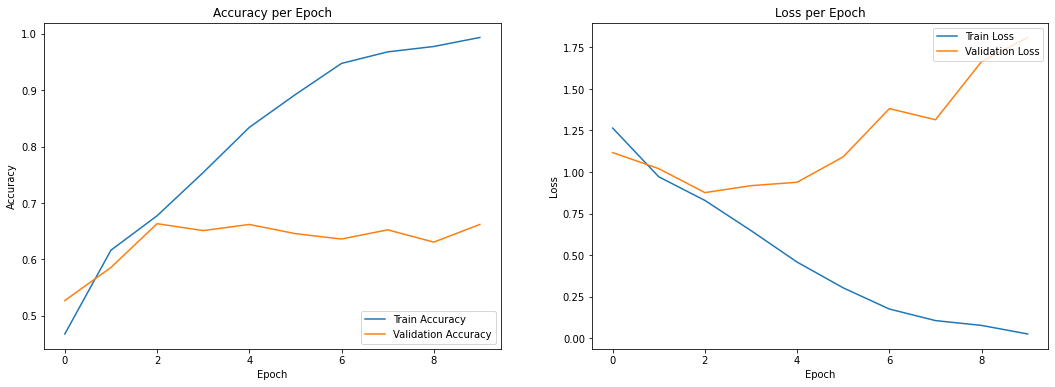

In [10]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy per Epoch')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss per Epoch')
plt.show()

# Data Augmentation

In [11]:
data_augmentation = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal', input_shape=(img_height, img_width, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

# Reconfigure Model with Data Augmentation and Dropout

In [12]:
model = tf.keras.models.Sequential()
model.add(data_augmentation)
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))
model.add(tf.keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(64, 3, padding = 'same', activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(5))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [13]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
92/92 [==============================] - 1s 15ms/step - loss: 1.2785 - accuracy: 0.4506 - val_loss: 1.1241 - val_accuracy: 0.5027
Epoch 2/10
92/92 [==============================] - 1s 14ms/step - loss: 1.0426 - accuracy: 0.5698 - val_loss: 0.9769 - val_accuracy: 0.6144
Epoch 3/10
92/92 [==============================] - 1s 14ms/step - loss: 0.9343 - accuracy: 0.6301 - val_loss: 0.9814 - val_accuracy: 0.6022
Epoch 4/10
92/92 [==============================] - 1s 14ms/step - loss: 0.8808 - accuracy: 0.6597 - val_loss: 0.9206 - val_accuracy: 0.6362
Epoch 5/10
92/92 [==============================] - 1s 14ms/step - loss: 0.8292 - accuracy: 0.6792 - val_loss: 0.8273 - val_accuracy: 0.6771
Epoch 6/10
92/92 [==============================] - 1s 14ms/step - loss: 0.7866 - accuracy: 0.6993 - val_loss: 0.7786 - val_accuracy: 0.6826
Epoch 7/10
92/92 [==============================] - 1s 14ms/step - loss: 0.7255 - accuracy: 0.7262 - val_loss: 0.7792 - val_accuracy: 0.6866
Epoch 8/10
92

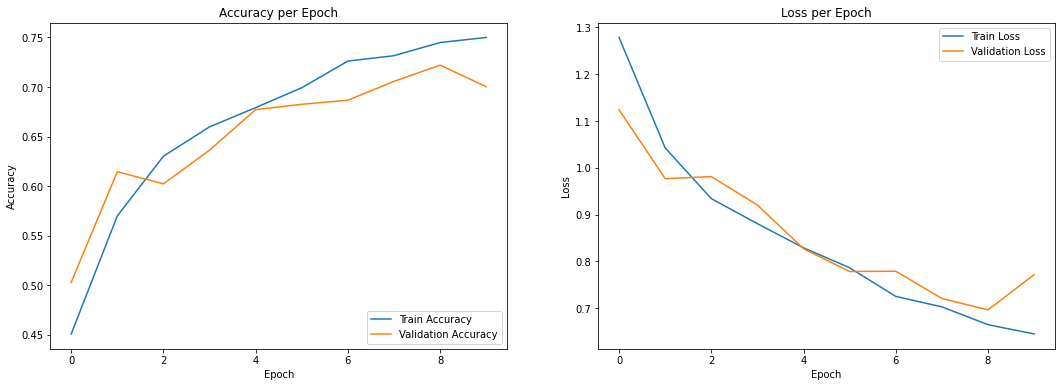

In [14]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy per Epoch')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss per Epoch')
plt.show()